In [33]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from source.read_pamap2 import read_pamap2, activityIDdict
from source.read_pamap2 import DatasetPAMAP2
from source.read_HAR_dataset import DatasetHARUML20
from source.tserie import TSerie
from source.read_open_dataset import read_open_dataset
from source.models.manifold.umap_fl import UMAP_FL
from cuml.manifold import UMAP
import matplotlib.pyplot as plt
sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
datasetName = 'HAR-UML20' # PAMAP2 or HAR-UML20
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 20
N_EPOCHS = 1000
RESULTS_PATH = 'results'
TS2VEC = True

MODE = 0 # 0 -> UMAP  -  1 -> TS2Vec - 2 -> SimCLR 
NET_EPOCHS = 7

In [35]:
if datasetName == 'PAMAP2':
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3',]
    signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3',]
    dataset = DatasetPAMAP2(mode = 'leave-one-subject')
    
elif datasetName ==  'HAR-UML20':
    signals = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z']
    dataset = DatasetHARUML20(mode = 'leave-one-subject')

elif datasetName == 'OpenDataset':
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'heart_rate ']
    # signals = ['heart_rate']
    signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    dataset = DatasetOpenDataset(mode = 'leave-one-subject')
    
    

In [36]:

dataset.loadData()
dataset.filterSignals(signals)


In [47]:
# Preparing data
ts_train = TSerie(dataset.X_train, dataset.y_train)
ts_test = TSerie(dataset.X_test, dataset.y_test)
# ts_train.center()
# ts_test.center()

if MODE == 0:
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()
    ts_train.center()
    ts_test.center()

    # Getting features
    model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
    ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    ts_test.features = model.transform(ts_test.features)

if MODE == 1:
    model = TS2Vec(
        input_dims=ts_train.D,
        device=0,
        output_dims=32,
        batch_size=8,
    )
    model.fit(ts_train.X, verbose=True,n_epochs = NET_EPOCHS)
    ts_train.features = model.encode(ts_train.X, encoding_window='full_series')
    ts_test.features = model.encode(ts_test.X, encoding_window='full_series')

In [48]:
import umap

reducer = UMAP(n_components=2)
train_coords = reducer.fit_transform(ts_train.features, y=ts_train.y)
test_coords = reducer.transform(ts_test.features)

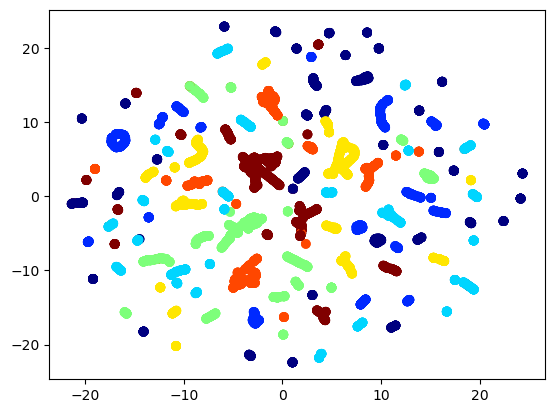

In [49]:
plt.scatter(train_coords[:,0], train_coords[:,1], c=ts_train.y, cmap='jet')

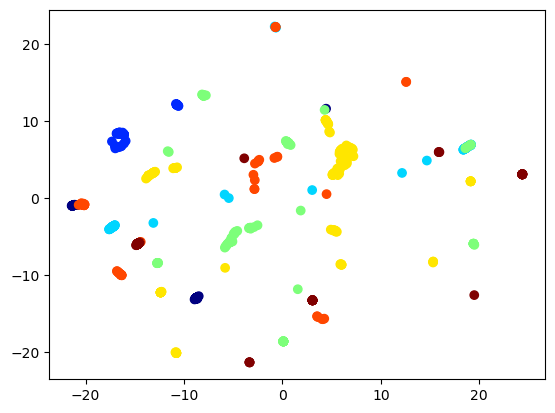

In [50]:
plt.scatter(test_coords[:,0], test_coords[:,1], c=ts_test.y, cmap='jet')

In [46]:
import sys
sys.path.insert(0, '/home/texs/Documentos/Repositories/mts_viz')

from server.source.storage import MTSStorage

In [35]:
storage = MTSStorage('pamap2')
storage.load()

# activities_map = {act: str(act) for act in np.unique(y)}
storage.add_mts(
    exp_name, X, 
    columns, 
    coords={'umap': coords}, 
    labels={'activities': y}, 
    labelsNames={'activities': activityIDdict},
    sampling = True,
    n_samples = 2000
)
storage.save()

NameError: name 'exp_name' is not defined